In [1]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

network = dataclasses.replace(MAINNET_APR_2023,
    # The external "interest rate" % p.a. on leased tokens.
    token_lease_fee=0.20,
    reward_decay=REWARD_DECAY,
)
# Number of epochs to simulate.
epochs = 3 * YEAR + 1
# Frequency of statistics output.
stats_interval = DAY

In [2]:
def compare_configurations(cfgs, title):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg)
              in cfgs.items()}

    plt.grid(axis='y', color='#EEE')
    for label, df in statss.items():
        plt.plot(df['day'], df['net_equity'], label=label)

    plt.plot()
    plt.title("Miner equity - " + title)
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()


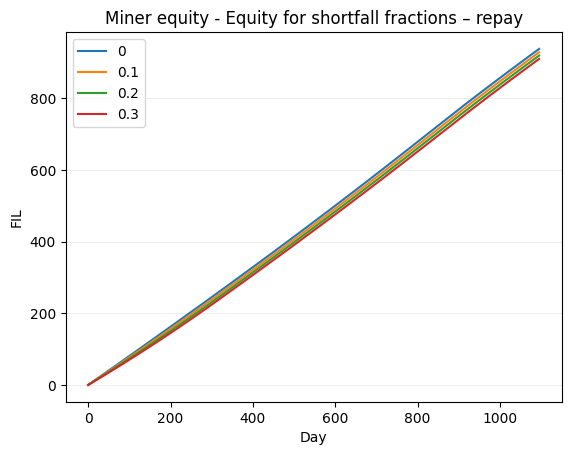

In [3]:
repay_miner_factory = RepayRatchetShortfallMinerState.factory(
    balance=0,  # Lease all tokens required.
    max_repayment_term=3 * YEAR,
    max_fee_reward_fraction=0.25,
    reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
)

partial_shortfall_cfgs = {str(shortfall_frac): SimConfig(
    network=network,
    strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, shortfall_frac),
    miner_factory=repay_miner_factory,
) for shortfall_frac in (0, 0.1, 0.2, 0.3)}

compare_configurations(partial_shortfall_cfgs, "Equity for shortfall fractions – repay")


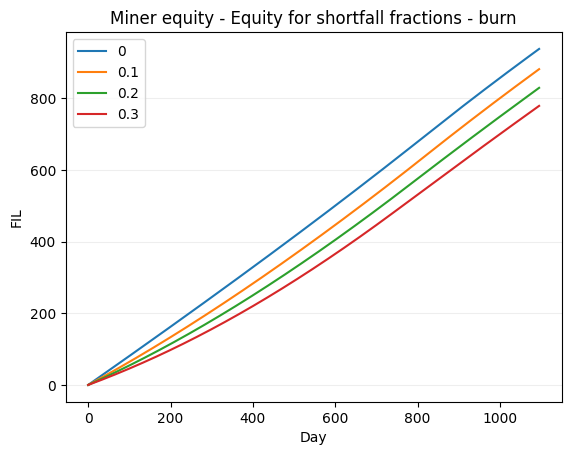

In [4]:
burn_miner_factory = BurnShortfallMinerState.factory(
    balance=0,
)

partial_shortfall_cfgs = {str(shortfall_frac): SimConfig(
    network=network,
    strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, shortfall_frac),
    miner_factory=burn_miner_factory,
) for shortfall_frac in (0, 0.1, 0.2, 0.3)}

compare_configurations(partial_shortfall_cfgs, "Equity for shortfall fractions - burn")

